# CA-04 Ensemble Models

The dataset is obtained from the Census Bureau and represents salaries of people along
with seven demographic variables. The following is a description of our dataset:
- Number of target classes: 2 ('>50K' and '<=50K') [ Labels: 1, 0 ]
- Number of attributes (Columns): 7
- Number of instances (Rows): 48,842

In [42]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
df = pd.read_csv("https://github.com/ArinB/MSBA-CA-03-Decision-Trees/blob/master/census_data.csv?raw=true")

In [44]:
df.head()

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,b. 31-40,b. Mid - Low,b. Mid,c. > 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,train,0
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,0
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. Mid,b. income,d. 36-40 & 56-60,train,0
3,b. 31-40,a. Low,c. High,a. = 0,b. Mid,a. 0-8,a. Low,b. income,e. 40-55,train,0
4,b. 31-40,e. High,c. High,a. = 0,a. Low,c. 13,c. Bachelors,b. income,b. 26-30 & 71-100,train,0


### Data Cleaning

In [45]:
df1 = df.copy()

In [46]:
# use str.split() to get rid of letters before values
df1['hours_per_week_bin'] = df1['hours_per_week_bin'].str.split(r".").str[1]
df1['occupation_bin'] = df1['occupation_bin'].str.split(r".").str[1]
df1['msr_bin'] = df1['msr_bin'].str.split(r".").str[1]
df1['capital_gl_bin'] = df1['capital_gl_bin'].str.split(r".").str[1]
df1['race_sex_bin'] = df1['race_sex_bin'].str.split(r".").str[1]
df1['education_num_bin'] = df1['education_num_bin'].str.split(r".").str[1]
df1['education_bin'] = df1['education_bin'].str.split(r".").str[1]
df1['workclass_bin'] = df1['workclass_bin'].str.split(r".").str[1]
df1['age_bin'] = df1['age_bin'].str.split(r".").str[1]

In [47]:
df1.head()

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,31-40,Mid - Low,Mid,> 0,High,13,Bachelors,income,36-40 & 56-60,train,0
1,0-30,High,High,= 0,High,13,Bachelors,income,40-55,train,0
2,31-40,Low,Mid,= 0,High,9-12,Mid,income,36-40 & 56-60,train,0
3,31-40,Low,High,= 0,Mid,0-8,Low,income,40-55,train,0
4,31-40,High,High,= 0,Low,13,Bachelors,income,26-30 & 71-100,train,0


In [48]:
# drop columns (eduation_bin has the same results to education_num_bin)
df1.drop(columns=['education_num_bin'], axis=1, inplace=True)

In [49]:
# encode categorical variables using one-hot encoding
df1 = pd.get_dummies(df1, columns=['hours_per_week_bin', 'occupation_bin', 'msr_bin', 'capital_gl_bin', 'race_sex_bin',
                                   'education_bin', 'workclass_bin', 'age_bin'], 
                     prefix=['hours_per_week', 'occupation', 'msr', 'capital_gl', 'race_sex',
                                   'education', 'workclass', 'age'])

In [68]:
# added this step in because I was getting a ValueError('feature_names may not contain [, ] or <') when trying to use XGBClassifier()
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df1.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df1.columns.values]

In [69]:
df1.head()

,flag,y,hours_per_week_ 0-30,hours_per_week_ 31-40,hours_per_week_ 41-50 & 61-70,hours_per_week_ 51-60,hours_per_week_ 71-100,occupation_ High,occupation_ Low,occupation_ Mid - High,...,education_ Low,education_ Masters,education_ Mid,workclass_ income,workclass_ no income,age_ 0-25,age_ 26-30 & 71-100,age_ 31-35 & 61-70,age_ 36-40 & 56-60,age_ 40-55
0,train,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,train,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
2,train,0,0,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,1,0
3,train,0,0,1,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
4,train,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0


In [70]:
df1.shape

(48842, 33)

In [71]:
# separate out train data
df_train = df1[df1['flag'] == 'train']
df_train.drop(columns=['flag'], axis=1, inplace=True)
df_train

/Users/michelle/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,y,hours_per_week_ 0-30,hours_per_week_ 31-40,hours_per_week_ 41-50 & 61-70,hours_per_week_ 51-60,hours_per_week_ 71-100,occupation_ High,occupation_ Low,occupation_ Mid - High,occupation_ Mid - Low,...,education_ Low,education_ Masters,education_ Mid,workclass_ income,workclass_ no income,age_ 0-25,age_ 26-30 & 71-100,age_ 31-35 & 61-70,age_ 36-40 & 56-60,age_ 40-55
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,0,1,0,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,1,0
3,0,0,1,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
4,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0,0,1,0,0,0,0,0,1,0,...,0,0,1,1,0,0,1,0,0,0
32557,1,0,1,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,1,0
32558,0,0,1,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,1,0
32559,0,1,0,0,0,0,0,0,0,1,...,0,0,1,1,0,1,0,0,0,0


In [72]:
# separate out test data
df_test = df1[df1['flag'] == 'test']
df_test.drop(columns=['flag'], axis=1, inplace=True)
df_test

/Users/michelle/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,y,hours_per_week_ 0-30,hours_per_week_ 31-40,hours_per_week_ 41-50 & 61-70,hours_per_week_ 51-60,hours_per_week_ 71-100,occupation_ High,occupation_ Low,occupation_ Mid - High,occupation_ Mid - Low,...,education_ Low,education_ Masters,education_ Mid,workclass_ income,workclass_ no income,age_ 0-25,age_ 26-30 & 71-100,age_ 31-35 & 61-70,age_ 36-40 & 56-60,age_ 40-55
32561,0,0,1,0,0,0,0,0,0,1,...,1,0,0,1,0,1,0,0,0,0
32562,0,0,0,1,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,1,0
32563,1,0,1,0,0,0,0,0,1,0,...,0,0,1,1,0,0,1,0,0,0
32564,1,0,1,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,1
32565,0,1,0,0,0,0,0,0,0,1,...,0,0,1,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
48838,0,0,1,0,0,0,0,0,0,1,...,0,0,1,0,1,0,0,1,0,0
48839,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
48840,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1


## Finding Optimal Value of a key Ensemble Method Hyper-parameter

Separate out y_test, x_test, y_train, and x_train data to build your model

In [73]:
y_test = df_test['y']
y_test

32561    0
32562    0
32563    1
32564    1
32565    0
        ..
48837    0
48838    0
48839    0
48840    0
48841    1
Name: y, Length: 16281, dtype: int64

In [74]:
x_test = df_test.loc[:, df_test.columns != "y"]
x_test

,hours_per_week_ 0-30,hours_per_week_ 31-40,hours_per_week_ 41-50 & 61-70,hours_per_week_ 51-60,hours_per_week_ 71-100,occupation_ High,occupation_ Low,occupation_ Mid - High,occupation_ Mid - Low,occupation_ Mid - Mid,...,education_ Low,education_ Masters,education_ Mid,workclass_ income,workclass_ no income,age_ 0-25,age_ 26-30 & 71-100,age_ 31-35 & 61-70,age_ 36-40 & 56-60,age_ 40-55
32561,0,1,0,0,0,0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,0
32562,0,0,1,0,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,1,0
32563,0,1,0,0,0,0,0,1,0,0,...,0,0,1,1,0,0,1,0,0,0
32564,0,1,0,0,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,1
32565,1,0,0,0,0,0,0,0,1,0,...,0,0,1,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
48838,0,1,0,0,0,0,0,0,1,0,...,0,0,1,0,1,0,0,1,0,0
48839,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
48840,0,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1


In [75]:
y_train = df_train['y']
y_train

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: y, Length: 32561, dtype: int64

In [76]:
x_train = df_train.loc[:, df_train.columns != "y"]
x_train

,hours_per_week_ 0-30,hours_per_week_ 31-40,hours_per_week_ 41-50 & 61-70,hours_per_week_ 51-60,hours_per_week_ 71-100,occupation_ High,occupation_ Low,occupation_ Mid - High,occupation_ Mid - Low,occupation_ Mid - Mid,...,education_ Low,education_ Masters,education_ Mid,workclass_ income,workclass_ no income,age_ 0-25,age_ 26-30 & 71-100,age_ 31-35 & 61-70,age_ 36-40 & 56-60,age_ 40-55
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,1,0,0,0,0,1,0,0,0,...,0,0,1,1,0,0,0,0,1,0
3,0,1,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1
4,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0,1,0,0,0,0,0,1,0,0,...,0,0,1,1,0,0,1,0,0,0
32557,0,1,0,0,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,1,0
32558,0,1,0,0,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,1,0
32559,1,0,0,0,0,0,0,0,1,0,...,0,0,1,1,0,1,0,0,0,0


## Random Forest

In [96]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import plot_roc_curve

In [97]:
from sklearn.ensemble import RandomForestClassifier

<AxesSubplot: >

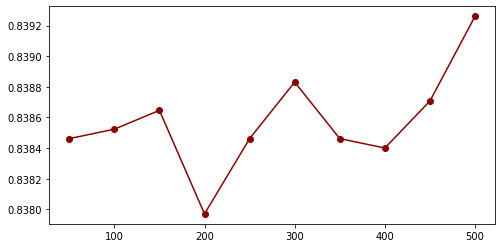

In [84]:
# accuracy v n_estimators
results = []
n_estimator = [50,100,150,200,250,300,350,400,450,500]
for values in n_estimator:
    model = RandomForestClassifier(n_estimators=values, random_state=101)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = np.mean(y_test==y_pred)
    results.append(accuracy)
    
plt.figure(figsize=(8,4))
pd.Series(results, n_estimator).plot(color="darkred",marker="o")

<AxesSubplot: >

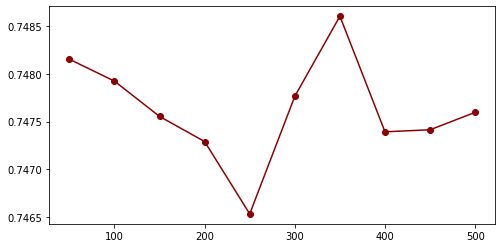

In [85]:
# AUC v n_estimators
results = []
n_estimator = [50,100,150,200,250,300,350,400,450,500]
for values in n_estimator:
    model = RandomForestClassifier(n_estimators=values, random_state=101)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    test_auc = roc_auc_score(y_test, y_pred)
    results.append(test_auc)
    
plt.figure(figsize=(8,4))
pd.Series(results, n_estimator).plot(color="darkred",marker="o")

n_estimator = 500 for best accuracy, n_estimator = 350 for best AUC

## AdaBoost

In [58]:
from sklearn.ensemble import AdaBoostClassifier

<AxesSubplot: >

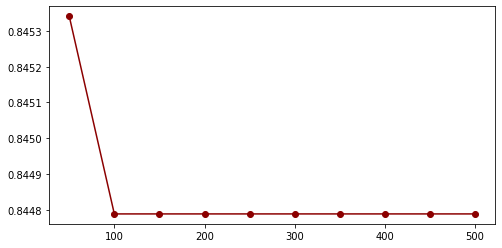

In [59]:
# accuracy v n_estimators
results = []
n_estimator = [50,100,150,200,250,300,350,400,450,500]
for values in n_estimator:
    model = AdaBoostClassifier(n_estimators=values, random_state=101)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = np.mean(y_test==y_pred)
    results.append(accuracy)
    
plt.figure(figsize=(8,4))
pd.Series(results, n_estimator).plot(color="darkred",marker="o")

<AxesSubplot: >

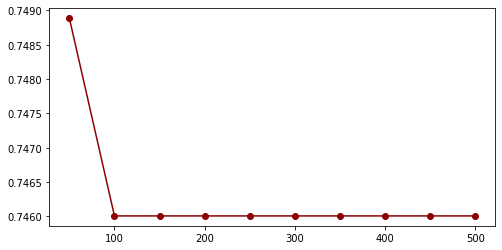

In [60]:
# AUC v n_estimators
results = []
n_estimator = [50,100,150,200,250,300,350,400,450,500]
for values in n_estimator:
    model = AdaBoostClassifier(n_estimators=values, random_state=101)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    test_auc = roc_auc_score(y_test, y_pred)
    results.append(test_auc)
    
plt.figure(figsize=(8,4))
pd.Series(results, n_estimator).plot(color="darkred",marker="o")

n_estimator = 50 for best accuracy and AUC scores

## Gradient Boosting

In [62]:
from sklearn.ensemble import GradientBoostingClassifier

<AxesSubplot: >

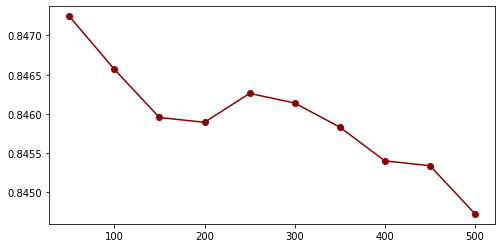

In [63]:
# accuracy v n_estimators
results = []
n_estimator = [50,100,150,200,250,300,350,400,450,500]
for values in n_estimator:
    model = GradientBoostingClassifier(n_estimators=values, random_state=101)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = np.mean(y_test==y_pred)
    results.append(accuracy)
    
plt.figure(figsize=(8,4))
pd.Series(results, n_estimator).plot(color="darkred",marker="o")

<AxesSubplot: >

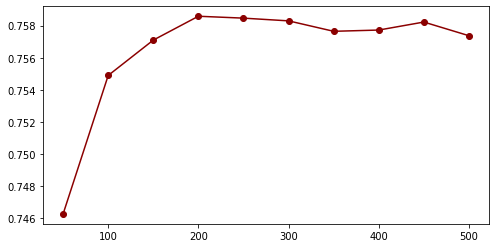

In [64]:
# AUC v n_estimators
results = []
n_estimator = [50,100,150,200,250,300,350,400,450,500]
for values in n_estimator:
    model = GradientBoostingClassifier(n_estimators=values, random_state=101)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    test_auc = roc_auc_score(y_test, y_pred)
    results.append(test_auc)
    
plt.figure(figsize=(8,4))
pd.Series(results, n_estimator).plot(color="darkred",marker="o")

n_estimator = 50 for best accuracy score, and n_estimator = 200 for best AUC score

## XGB

In [65]:
from xgboost import XGBClassifier

<AxesSubplot: >

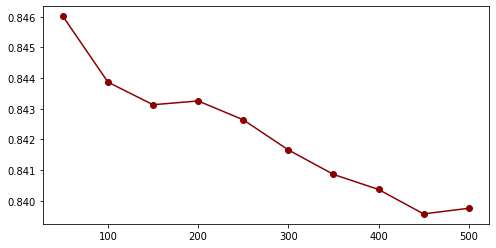

In [77]:
# accuracy v n_estimators

results = []
n_estimator = [50,100,150,200,250,300,350,400,450,500]
for values in n_estimator:
    model = XGBClassifier(n_estimators=values, random_state=101)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = np.mean(y_test==y_pred)
    results.append(accuracy)
    
plt.figure(figsize=(8,4))
pd.Series(results, n_estimator).plot(color="darkred",marker="o")

<AxesSubplot: >

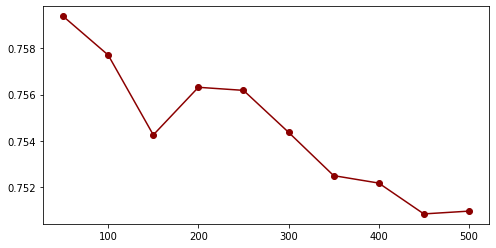

In [78]:
# AUC v n_estimators
results = []
n_estimator = [50,100,150,200,250,300,350,400,450,500]
for values in n_estimator:
    model = XGBClassifier(n_estimators=values, random_state=101)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    test_auc = roc_auc_score(y_test, y_pred)
    results.append(test_auc)
    
plt.figure(figsize=(8,4))
pd.Series(results, n_estimator).plot(color="darkred",marker="o")

n_estimators = 50 for best accuracy and AUC scores

1. Write your observations about the Classifier’s behavior with respect to the number of estimators

RandomForest: for accuracy, there was a big drop at 200 estimators and a small drop at 400, the highest point was at 500. The AUC had a low point at 250 and a high point at 350.
AdaBoost: accuracy and AUC had a peak at 50, then dropped and stayed low for the rest of the estimators.
Gradient Boosting: accuracy started high at 50 estimators then gradually decreased, AUC started low at 50 then peaked at 200 and stayed pretty high.
XGB: accuracy and AUC started high at 50 estimators then gradually decreased.

2. Is there an optimal value of the estimator within the given range?

Yes, it is different for each Classifier, but the most common n_estimator value was 50. 

## Compare Performance

In [95]:
# Create table for best values of accuracy and AUC for 4 models (Random Forest, AdaBoost, Gradient Boost, XGB)
models = {
    "Random Forest": RandomForestClassifier(n_estimators=500, random_state=101),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=101),
    "Gradient Boost": GradientBoostingClassifier(n_estimators=50, random_state=101),
    "XGB": XGBClassifier(n_estimators=50, random_state=101)
}

# initialize empty table
table_data = []
header = ["Model", "Accuracy", "AUC"]

# loop through each model and calculate accuracy and AUC
for model_name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    table_data.append([model_name, accuracy, auc])

# create table from data
table_df = pd.DataFrame(table_data, columns=header)
table_df.set_index("Model", inplace=True)
print(table_df)

                Accuracy       AUC
Model                             
Random Forest   0.839260  0.747597
AdaBoost        0.845341  0.748884
Gradient Boost  0.847245  0.746269
XGB             0.846017  0.759383


I wanted to run the loop through each model and calculate accuracy first (with the n_estimators as seen above) and then append a new column for the AUC scores and calculate AUC with different n_estimators. According to the models run previously, the optimal n_estimators for RandomForest and Gradient Boost for AUC were 250 and 350. 

The model with the best collective accuracy and AUC is 